In [328]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt 
import numpy as np
import math
from pprint import pprint
from config import openWeatherKey

In [329]:
weatherDisasterCSV = "Resources/disaster_data.csv"
wDisaster_df = pd.read_csv(weatherDisasterCSV)
desiredColumns = ["Dis No", "Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Location", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI"]
wDisaster_df = wDisaster_df.loc[wDisaster_df["ISO"] == "USA", desiredColumns]
wDisaster_df

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Entry Criteria,ISO,Location,Start Month,End Month,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI
2,2000-0080-USA,2000,80,Hydrological,Flood,Riverine flood,NaN,Affect,USA,"Kentucky, Ohio provinces",2,2.0,3.0,NaN,231.0,NaN,231.0,NaN,NaN,67.355759
3,2000-0500-USA,2000,500,Hydrological,Flood,Riverine flood,NaN,Affect,USA,"Morris, Sussex districts (New Jersey province)",8,8.0,NaN,NaN,175.0,NaN,175.0,NaN,166000.0,67.355759
4,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",1,1.0,4.0,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759
5,2000-9712-USA,2000,9712,Climatological,Drought,Drought,NaN,Affected,USA,Wyoming province,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.355759
6,2000-0838-USA,2000,838,Meteorological,Storm,Convective storm,Winter storm/Blizzard,Kill,USA,"Texas, Oklahoma, New Mexico, Arkansas, Missour...",12,12.0,57.0,34.0,NaN,NaN,34.0,200500.0,10000.0,67.355759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,2019-0307-USA,2019,307,Hydrological,Flood,NaN,NaN,Affected,USA,"Lincolnton region (Lincoln County, North Carol...",6,6.0,3.0,NaN,600.0,NaN,600.0,NaN,NaN,100.000000
533,2020-0148-USA,2020,148,Meteorological,Storm,Convective storm,Tornado,Kill,USA,"Louisiana, Texas, Mississippi, South Carolina,...",4,4.0,38.0,200.0,NaN,NaN,200.0,NaN,1000000.0,NaN
534,2020-0011-USA,2020,11,Meteorological,Storm,Convective storm,Severe storm,Kill,USA,"Texas, Oklahoma, Missouri, Arkansas, Louisiana...",1,1.0,12.0,NaN,NaN,NaN,NaN,NaN,1200000.0,NaN
535,2020-0082-USA,2020,82,Meteorological,Storm,Convective storm,Tornado,Waiting,USA,"Nashville (Tennessee), Kentucky, Missouri, Mis...",3,3.0,25.0,300.0,12000.0,NaN,12300.0,NaN,1100000.0,NaN


In [330]:
newData = {
    "Location": [],
    "Dis No": []
}

for index, row in wDisaster_df.iterrows():
    #print(type(newData["Location"]))
    if type(row["Location"]) is str:
        for location in row["Location"].split(","):
            newData["Location"].append(location)
            newData["Dis No"].append(row["Dis No"])
splitLocations_df = pd.DataFrame(newData)
splitLocations_df

,Location,Dis No
0,Kentucky,2000-0080-USA
1,Ohio provinces,2000-0080-USA
2,Morris,2000-0500-USA
3,Sussex districts (New Jersey province),2000-0500-USA
4,Alabama,2000-0919-USA
...,...,...
4019,Georgia,2020-0082-USA
4020,Texas,2020-0082-USA
4021,errebonne,2020-0219-USA
4022,Plaquemines,2020-0219-USA


In [331]:
splitLocations_df["Lat"] = ""
splitLocations_df["Long"] = ""
locations = splitLocations_df["Location"]
splitLocations_df

,Location,Dis No,Lat,Long
0,Kentucky,2000-0080-USA,,
1,Ohio provinces,2000-0080-USA,,
2,Morris,2000-0500-USA,,
3,Sussex districts (New Jersey province),2000-0500-USA,,
4,Alabama,2000-0919-USA,,
...,...,...,...,...
4019,Georgia,2020-0082-USA,,
4020,Texas,2020-0082-USA,,
4021,errebonne,2020-0219-USA,,
4022,Plaquemines,2020-0219-USA,,


In [332]:
coordCSV = "output_data/NEW_coordinates.csv"

In [333]:
coordLocations_df = pd.read_csv(coordCSV)
#This array is stored for potential future reference if adding new data from different dataframes
cleanedCoordsIndex = coordLocations_df.index
coordLocations_df = coordLocations_df.loc[:, ['Location', 'Dis No', 'Lat', 'Long']]
coordLocations_df

,Location,Dis No,Lat,Long
0,Kentucky,2000-0080-USA,34.61,-92.66
1,Morris,2000-0500-USA,40.83,-74.53
2,Alabama,2000-0919-USA,32.75,-86.75
3,Georgia,2000-0919-USA,32.75,-83.50
4,Louisiana,2000-0919-USA,31.00,-92.00
...,...,...,...,...
2856,Kentucky,2020-0082-USA,34.61,-92.66
2857,Missouri,2020-0082-USA,38.25,-92.50
2858,Mississippi,2020-0082-USA,32.75,-89.75
2859,Georgia,2020-0082-USA,32.75,-83.50


In [334]:
Combined_df =pd.merge(wDisaster_df, coordLocations_df, on='Dis No')
Combined_df

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Entry Criteria,ISO,Location_x,...,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Location_y,Lat,Long
0,2000-0080-USA,2000,80,Hydrological,Flood,Riverine flood,NaN,Affect,USA,"Kentucky, Ohio provinces",...,NaN,231.0,NaN,231.0,NaN,NaN,67.355759,Kentucky,34.61,-92.66
1,2000-0500-USA,2000,500,Hydrological,Flood,Riverine flood,NaN,Affect,USA,"Morris, Sussex districts (New Jersey province)",...,NaN,175.0,NaN,175.0,NaN,166000.0,67.355759,Morris,40.83,-74.53
2,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,Alabama,32.75,-86.75
3,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,Georgia,32.75,-83.50
4,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,Louisiana,31.00,-92.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,2020-0082-USA,2020,82,Meteorological,Storm,Convective storm,Tornado,Waiting,USA,"Nashville (Tennessee), Kentucky, Missouri, Mis...",...,300.0,12000.0,NaN,12300.0,NaN,1100000.0,NaN,Kentucky,34.61,-92.66
2857,2020-0082-USA,2020,82,Meteorological,Storm,Convective storm,Tornado,Waiting,USA,"Nashville (Tennessee), Kentucky, Missouri, Mis...",...,300.0,12000.0,NaN,12300.0,NaN,1100000.0,NaN,Missouri,38.25,-92.50
2858,2020-0082-USA,2020,82,Meteorological,Storm,Convective storm,Tornado,Waiting,USA,"Nashville (Tennessee), Kentucky, Missouri, Mis...",...,300.0,12000.0,NaN,12300.0,NaN,1100000.0,NaN,Mississippi,32.75,-89.75
2859,2020-0082-USA,2020,82,Meteorological,Storm,Convective storm,Tornado,Waiting,USA,"Nashville (Tennessee), Kentucky, Missouri, Mis...",...,300.0,12000.0,NaN,12300.0,NaN,1100000.0,NaN,Georgia,32.75,-83.50


In [335]:
FirstQuintant1 = Combined_df.loc[Combined_df["Lat"] > 38, :].reset_index(drop=True)
FirstQuintant2 = FirstQuintant1.loc[FirstQuintant1["Long"] > -90, :].reset_index(drop=True)
FirstQuintant2

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Entry Criteria,ISO,Location_x,...,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Location_y,Lat,Long
0,2000-0500-USA,2000,500,Hydrological,Flood,Riverine flood,NaN,Affect,USA,"Morris, Sussex districts (New Jersey province)",...,NaN,175.0,NaN,175.0,NaN,166000.0,67.355759,Morris,40.83,-74.53
1,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,New York,40.71,-74.01
2,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,"Alabama, Georgia, Louisiana, North Carolina, S...",...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,Pennsylvania,40.27,-76.91
3,2000-0338-USA,2000,338,Meteorological,Storm,Convective storm,Tornado,Declar/Int,USA,"Adams, Columbia, Crawford, Dane, Dodge, Grant,...",...,NaN,NaN,NaN,NaN,NaN,28500.0,67.355759,Dane,48.08,-80.02
4,2000-0338-USA,2000,338,Meteorological,Storm,Convective storm,Tornado,Declar/Int,USA,"Adams, Columbia, Crawford, Dane, Dodge, Grant,...",...,NaN,NaN,NaN,NaN,NaN,28500.0,67.355759,Green,40.95,-81.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2018-0468-USA,2018,468,Climatological,Wildfire,NaN,NaN,SigDam,USA,"Thousand Oaks, Oak Park, Westlake Village, Ago...",...,3.0,NaN,NaN,3.0,4000000.0,5200000.0,98.219991,Westlake Village,42.33,-88.00
941,2019-0086-USA,2019,86,Hydrological,Flood,NaN,NaN,Declar,USA,"Amador, Glenn, Lake, Mendocino, Sonoma, Humbol...",...,NaN,6000.0,NaN,6000.0,NaN,NaN,100.000000,Lake,42.33,-88.00
942,2019-0624-USA,2019,624,Meteorological,Storm,Convective storm,Severe storm,Kill,USA,"Missouri, Nebraska, Indiana, Kansas, Louisiana...",...,NaN,NaN,NaN,NaN,175000.0,235000.0,100.000000,Indiana,40.00,-86.25
943,2019-0116-USA,2019,116,Hydrological,Flood,Riverine flood,NaN,Affected,USA,"Nebraska, Iowa, Wisconsin, Missouri, Kansas, I...",...,NaN,2000.0,NaN,2000.0,2500000.0,10000000.0,100.000000,Illinois,40.00,-89.25


In [336]:
desiredColumns = ["Dis No","Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI","Location_y","Lat","Long"]
FirstQuintant = FirstQuintant2.loc[:, desiredColumns].reset_index(drop=True)
FirstQuintant.rename(columns={'Location_y': 'Location'}, inplace=True)
FirstQuintant

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Entry Criteria,ISO,Start Month,...,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Location,Lat,Long
0,2000-0500-USA,2000,500,Hydrological,Flood,Riverine flood,NaN,Affect,USA,8,...,NaN,175.0,NaN,175.0,NaN,166000.0,67.355759,Morris,40.83,-74.53
1,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,1,...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,New York,40.71,-74.01
2,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,1,...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,Pennsylvania,40.27,-76.91
3,2000-0338-USA,2000,338,Meteorological,Storm,Convective storm,Tornado,Declar/Int,USA,5,...,NaN,NaN,NaN,NaN,NaN,28500.0,67.355759,Dane,48.08,-80.02
4,2000-0338-USA,2000,338,Meteorological,Storm,Convective storm,Tornado,Declar/Int,USA,5,...,NaN,NaN,NaN,NaN,NaN,28500.0,67.355759,Green,40.95,-81.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2018-0468-USA,2018,468,Climatological,Wildfire,NaN,NaN,SigDam,USA,11,...,3.0,NaN,NaN,3.0,4000000.0,5200000.0,98.219991,Westlake Village,42.33,-88.00
941,2019-0086-USA,2019,86,Hydrological,Flood,NaN,NaN,Declar,USA,2,...,NaN,6000.0,NaN,6000.0,NaN,NaN,100.000000,Lake,42.33,-88.00
942,2019-0624-USA,2019,624,Meteorological,Storm,Convective storm,Severe storm,Kill,USA,12,...,NaN,NaN,NaN,NaN,175000.0,235000.0,100.000000,Indiana,40.00,-86.25
943,2019-0116-USA,2019,116,Hydrological,Flood,Riverine flood,NaN,Affected,USA,3,...,NaN,2000.0,NaN,2000.0,2500000.0,10000000.0,100.000000,Illinois,40.00,-89.25


In [337]:
#Creating a trimmed DF of dropped duplicates for more accurate calculations
FirstQuintantUniqueForCalc = FirstQuintant.drop_duplicates(subset="Dis No", keep="first")
FirstQuintantUniqueForCalc

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Entry Criteria,ISO,Start Month,...,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Location,Lat,Long
0,2000-0500-USA,2000,500,Hydrological,Flood,Riverine flood,NaN,Affect,USA,8,...,NaN,175.0,NaN,175.0,NaN,166000.0,67.355759,Morris,40.83,-74.53
1,2000-0919-USA,2000,919,Meteorological,Storm,NaN,NaN,SigDam,USA,1,...,NaN,NaN,NaN,NaN,280000.0,350000.0,67.355759,New York,40.71,-74.01
3,2000-0338-USA,2000,338,Meteorological,Storm,Convective storm,Tornado,Declar/Int,USA,5,...,NaN,NaN,NaN,NaN,NaN,28500.0,67.355759,Dane,48.08,-80.02
5,2000-0360-USA,2000,360,Meteorological,Storm,Convective storm,Severe storm,Declar/Int,USA,5,...,NaN,NaN,NaN,NaN,NaN,NaN,67.355759,Henry,41.11,-89.36
8,2000-0232-USA,2000,232,Hydrological,Flood,Flash flood,NaN,Affect,USA,5,...,NaN,NaN,2000.0,2000.0,NaN,NaN,67.355759,Franklin,39.97,-83.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2018-0468-USA,2018,468,Climatological,Wildfire,NaN,NaN,SigDam,USA,11,...,3.0,NaN,NaN,3.0,4000000.0,5200000.0,98.219991,Oak Park,41.88,-87.78
941,2019-0086-USA,2019,86,Hydrological,Flood,NaN,NaN,Declar,USA,2,...,NaN,6000.0,NaN,6000.0,NaN,NaN,100.000000,Lake,42.33,-88.00
942,2019-0624-USA,2019,624,Meteorological,Storm,Convective storm,Severe storm,Kill,USA,12,...,NaN,NaN,NaN,NaN,175000.0,235000.0,100.000000,Indiana,40.00,-86.25
943,2019-0116-USA,2019,116,Hydrological,Flood,Riverine flood,NaN,Affected,USA,3,...,NaN,2000.0,NaN,2000.0,2500000.0,10000000.0,100.000000,Illinois,40.00,-89.25


In [338]:
Yearly_TotalsRaw = FirstQuintantUniqueForCalc.groupby("Year").sum()
desiredColumns = ["Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
Yearly_Totals = Yearly_TotalsRaw.loc[:, desiredColumns].reset_index(drop=False)
Yearly_Totals.rename(columns={"Insured Damages ('000 US$)" : "Insured Damages", "Total Damages ('000 US$)" : "Total Damages"}, inplace=True)
Yearly_CountRaw = FirstQuintantUniqueForCalc.groupby("Year").count()
Yearly_Count = Yearly_CountRaw.loc[:, "Dis No"].reset_index(drop=False)
YearlyMerged = pd.merge(Yearly_Count, Yearly_Totals, on='Year')

# Cost per Year
# Insured per Year
# Events per Year

Text(0.5, 1.0, 'Total Damanges and Insured Damanges per Year')

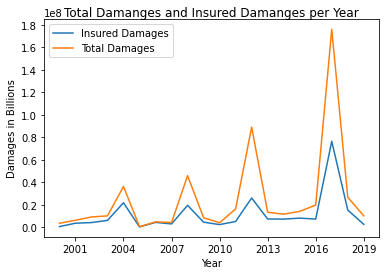

In [339]:
# Total Damanges and Insured Damanges per Year
PlotThis = ["Insured Damages","Total Damages"]
df = YearlyMerged
Damages = df.plot(kind="line",x="Year",y=PlotThis)
Damages.xaxis.set_major_locator(plt.MaxNLocator(8))
Damages.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylabel('Damages in Billions')  
  
# displaying the title 
plt.title(label='Total Damanges and Insured Damanges per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Disasters per Year')

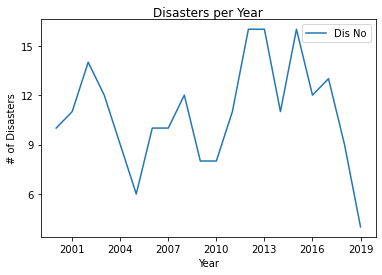

In [340]:
# Disasters per Year
PlotThis = ["Dis No"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('# of Disasters')  
  
# displaying the title 
plt.title(label='Disasters per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Total Death and Injuries per Year')

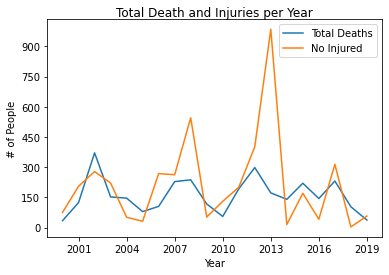

In [341]:
# Total Death and Injuries per Year
PlotThis = ["Total Deaths", "No Injured"]
df = YearlyMerged
DeathInjury = df.plot(kind="line",x="Year",y=PlotThis)
DeathInjury.xaxis.set_major_locator(plt.MaxNLocator(8))
DeathInjury.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Total Death and Injuries per Year',  
          fontweight=10,  
          pad='2.0')


Text(0.5, 1.0, 'Homeless due to Disasters per Year')

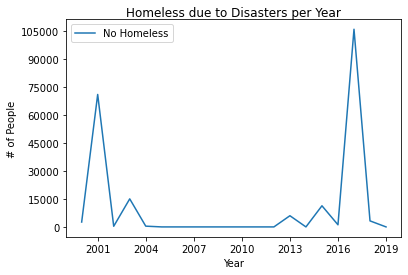

In [342]:
# Homeless due to Disasters per Year
PlotThis = ["No Homeless"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Homeless due to Disasters per Year',  
          fontweight=10,  
          pad='2.0')

In [357]:
Test = FirstQuintantUniqueForCalc.groupby('Year')['Disaster Subtype'].value_counts()
Test

Year  Disaster Subtype
2000  Convective storm    3
      Forest fire         3
      Flash flood         1
      Riverine flood      1
2001  Convective storm    6
                         ..
2018  Flash flood         1
      Forest fire         1
      Riverine flood      1
2019  Convective storm    2
      Riverine flood      1
Name: Disaster Subtype, Length: 74, dtype: int64

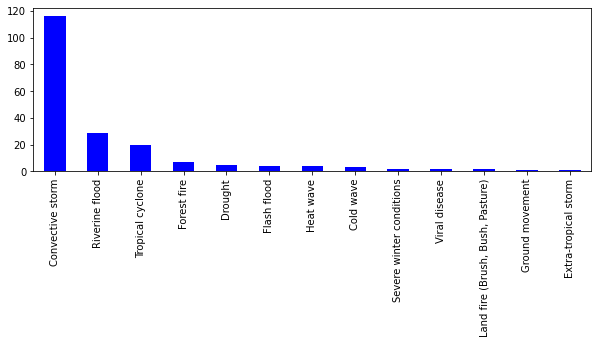

In [196]:
# Bar Graph by Type of Event
regionDisSubTypeCount = FirstQuintantUniqueForCalc["Disaster Subtype"].value_counts()
plt.figure(figsize=(10,3))
regionDisSubTypeCount.plot(kind="bar", facecolor="blue", rot=90)
